# 2.1 Flow Models
---

## 1. Fundamental Definition
Flow models 是由 ODEs (Ordinary Differential Equations) 所建構而成的模型，其中有三個重要的元素:
* Trajectory
* Vector Filed (VF)
* Flow

**Trajectory** 是在描述 ODE 的空間中的路徑，可以想像成一顆粒子在空間中隨時間移動的路徑。它有以下形式:
$$
X : [0, 1] \rightarrow \mathbb{R}^d, \quad t \mapsto X_t
$$

**VF** 是粒子在空間中隨時間移動的方向 (或者可以想像成是方向向量)，我們會假設粒子皆遵循VF的方向在移動。它有以下形式:
$$
u : \mathbb{R}^d \times [0, 1] \rightarrow \mathbb{R}^d, \quad (x, t) \mapsto u_t(x)
$$

透過定義 **Trajectory** 和 **VF**，我們可以定義以下 ODE 問題: 給定初始條件 $X_0 = x_0$，則
$$
\frac{d}{dt} X_t = u_t(X_t)
$$

**Flow** 則是上述 ODE 問題的解。Flow $\psi$ 是一個 function
$$
\psi : \mathbb{R}^d \times [0, 1] \mapsto \mathbb{R}^d, \quad (x_0, t) \mapsto \psi_t (x_0) 
$$

該解有以下形式，給定初始條件為 $\psi_0(x_0) = x_0$，則
$$
\frac{d}{dt} \psi_t(X_t) = u_t(\psi_t(x_0))
$$

<span style="color: red">Keypoint</span>: ***Vector fileds define ODEs whose solutions are flows.***

---

## 2. Simulating an ODE
數值微分方程中有提供一個基本的模擬方法，**Euler method**。

給定初始條件 $X_0 = x_0$，Euler method 有以下迭代公式，
$$
X_{t + h} = X_t + h u_t(X_t), \quad t = 0, h, 2h, \ldots, 1 - h
$$
其中，$h = 1 / n$ 為 step size。

<span style="color: grey">**Note**: 此處可以直接放 $u_t(X_t)$ 是因為 $\frac{d}{dt} X_t = u_t(X_t)$。</span>

---

## 3. Flow Models
Flow models 是由 ODEs 所描述，也就是
$$
X_0 \sim p_{\text{init}} \\
\frac{d}{dt} X_t = u_t^\theta(X_t)
$$
其中 $p_{\text{init}}$ 為一個任意分佈，以及 $u_t^\theta(X_t)$ 為由類神經網路搭配參數 $\theta$ 所建構的 VF。

Flow models 的目標在透過上述的 learning process 使得最後得到的 $X_1$ 和 $p_{\text{data}}$ 夠相似，也就是我們相信 $X_1$ 是來自 $p_{\text{data}}$。

<img src="material/chap2/alg_1.jpeg" alt="smiley" height="350px" width="600px">

---

## 4. Simulation
以下模擬展示，在 flow model 作用下單個粒子的 trajectory 和多個粒子的 trajectories

In [1]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# set up an arbitrary neural network for flow step
class VF_step_flow(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(VF_step_flow, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [3]:
def flow_model(num_particle: int, step_size: int, random_seed: Optional[int]=None) -> list:
    
    """
    Simulate the flow field of particles using a neural network model.
    Args:
        num_particle (int): Number of particles to simulate.
        step_size (int): Number of steps for the simulation.
        random_seed (int, optional): Random seed for initial positions. Defaults to None.
    Returns:
        list: A list of numpy arrays representing the history of particle positions.
    """
    
    if random_seed is not None:
        np.random.seed(random_seed)
    
    # generate initial positions of particles
    X = np.random.normal(0, 1, size=(num_particle, 2))
    X_input = torch.tensor(X, dtype=torch.float32, requires_grad=False).to(device)
    X_history = [X]

    model = VF_step_flow(input_size=2, hidden_size=10, output_size=2).to(device)
    
    t = 0   # time step
    h = 1 / step_size
    
    # main
    while t < 1:
        for _ in range(step_size):
            with torch.no_grad():
                X_input = X_input + h * model(X_input)
            X_history.append(X_input.cpu().detach().numpy())
            t = t + h
    
    return X_history

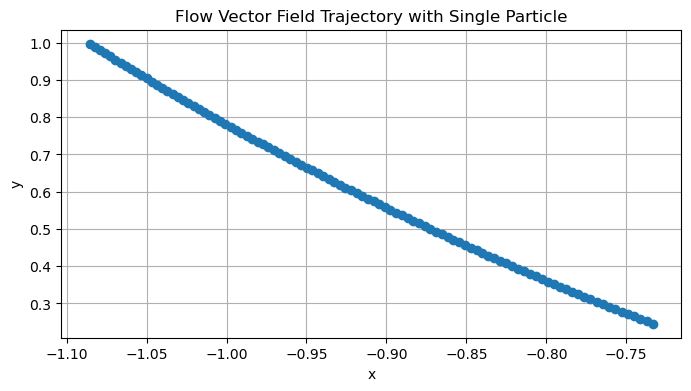

In [4]:
# simulate the trajectory of a single particle in the flow model
single_particle_flow = flow_model(num_particle=1, step_size=100, random_seed=123)

x = [single_particle_flow[i][0][0] for i in range(len(single_particle_flow))]
y = [single_particle_flow[i][0][1] for i in range(len(single_particle_flow))]

plt.figure(figsize=(8, 4))
plt.plot(x, y, marker="o")
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Flow Vector Field Trajectory with Single Particle")
plt.show()

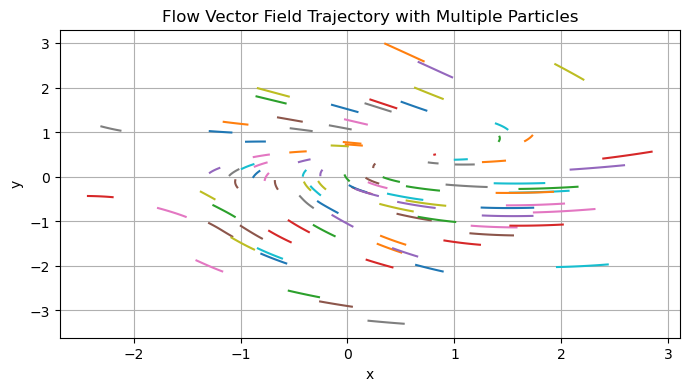

In [5]:
# simulate the trajectory of multiple particles in the flow model
multiple_particle_flow = flow_model(num_particle=100, step_size=100, random_seed=123)

particle = {
    f"particle_{j}": [multiple_particle_flow[i][j] for i in range(len(multiple_particle_flow))]
    for j in range(len(multiple_particle_flow[0]))
}

plt.figure(figsize=(8, 4))
for key in particle.keys():
    plt.plot(
        [particle[key][i][0] for i in range(len(particle[key]))], 
        [particle[key][i][1] for i in range(len(particle[key]))]
    )
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Flow Vector Field Trajectory with Multiple Particles")
plt.show()

# 2.2 Diffusion Models

---
## 1. Fundamental Definition
Diffusion models 是由 SDEs (Stochastic Differential Equations) 所建構而成的模型，其元素與 flow models 類似，差別在於 diffusion models 中的 trajectory 具有隨機性。

對於這樣有隨機性的 trajectory 我們可以將其視為一個隨機過程 (stochastic process) $(X_t)_{0 \leq t \leq 1}$，也就是
$$
X_t \ \text{is a random variable for every} \ 0 \leq t \leq 1
$$
$$
X: [0, 1] \rightarrow \mathbb{R}^d, \quad t \mapsto X_t \ \text{is a random trajectory for every draw of} \ X
$$

### Brownian Motion
在 SDEs 中，**Brownian motion** 常被用於描述隨機項 (stochastic term)。對於一個隨機過程，$(W_t)_{0 \leq t \leq 1}$，我們有以下性質:
1. $W_0 = 0$.
2. **normal increments**: $W_t - W_s \sim N(0, t - s)$ for all $0 < s < t$.
3. **independent increments**: For any $0 \leq t_0 \leq t_1 \leq \ldots \leq t_n = 1$, the increments $W_{t_1} - W_{t_0}, \ldots, W_{t_n} - W_{t_{n-1}}$ are independent random variables.

滿足這三個性質的隨機過程就稱為 Brownian motion 或是 Wiener process。

Brownian motion 可以由以下迭代式進行模擬，給定初始條件 $W_0 = 0$，則
$$
W_{t + h} = W_t + \sqrt{h} \varepsilon, \quad \varepsilon \sim N(0, 1)
$$

### From ODEs to SDEs
由於 SDEs 中包含了隨機項，因此無法像 ODEs 一樣可以對其進行微分，因此我們需要做一些適當的處理。

首先，我們需要對 ODEs 做**離散化**：
$$
\frac{d}{dt} X_t = u_t(X_t) \\
\Leftrightarrow \frac{1}{h} (X_{t + h} - X_t) = u_t(X_t) + R_t(h) \\
\Leftrightarrow X_{t + h} = X_t + h u_t(X_t) + h R_t(h)
$$
其中 $R_t(h)$ 為誤差項，滿足 $\displaystyle \lim_{h \rightarrow 0} R_t(h) = 0$。

接著，我們在上述離散化後的 ODEs 中加入隨機項，也就是 Brownian motion，
$$
X_{t + h} = X_t + h u_t(X_t) + \sigma_t (W_{t + h} - W_t)
$$
其中 $h u_t(X_t)$ 為固定項 (deterministic term)、$W_{t + h} - W_t$ 為隨機項，以及$\sigma_t$ 為擴散係數 (diffusion coefficient)。從 Brownian motion 的性質中，我們可以得到 $W_{t + h} - W_t \sim N(0, h)$。

最後，我們就可以得到 SDEs 問題，給定初始條件為 $X_0 = x_0$ 以及 $W_0 = 0$，則
$$
dX_t = u_t(X_t)dt + \sigma_t dW_t
$$

<span style="color: grey">**Note**: 此處並沒有 flows 這個解，僅能依賴於數值解。</span>

---

## 2. Simulation an SDE
數值微分方程中有提供一個基本的模擬方法，**Euler-Maruyama method**。

給定初始條件 $X_0 = x_0$，Euler-Maruyama method 有以下迭代公式，
$$
X_{t + h} = X_t + h u_t(X_t) + \sqrt{h} \sigma_t \varepsilon, \quad \varepsilon \sim N(0, 1)\ \text{and} \ t = 0, h, 2h, \ldots, 1 - h
$$
其中，$h = 1 / n$ 為 step size。

---

## 3. Diffusion Models
Diffusion models 是由 SDEs 所描述，也就是
$$
X_0 \sim p_{\text{init}} \\
dX_t = u_t^\theta(X_t) dt + \sigma_t dW_t
$$
其中 $p_{\text{init}}$ 為一個任意分佈，以及 $u_t^\theta(X_t)$ 為由類神經網路搭配參數 $\theta$ 所建構的 VF。

Diffusion models 的目標同樣是透過上述的 learning process 使得最後得到的 $X_1$ 和 $p_{\text{data}}$ 夠相似。

<img src="material/chap2/alg_2.jpeg" alt="smiley" height="350px" width="650px">

---

## 4. Simulation
以下模擬展示:
1. 1-D Brownian motion 路徑過程
2. 在 diffusion model 作用下，單個粒子的 trajectory 和多個粒子的 trajectories
3. 在 diffusion model 作用下，考慮不同擴散係數對於 trajectory 的影響

In [6]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
def brownian_motion(num_path: int, num_period: float, step_size: int, random_seed: Optional[int]=None) -> np.ndarray:

    """
    Simulate the 1-D Brownian motion.
    Args:
        num_path (int): Number of paths to simulate.
        num_period (float): Total time duration.
        step_size (int): Number of discrete time steps.
        random_seed (int, optional): Random seed for reproducibility. Defaults to None.
    Returns:
        np.ndarray: A 1D array of shape (num_path, step_size) representing the Brownian motion paths.
    """
    
    if random_seed is not None:
        np.random.seed(random_seed)

    dt = num_period / step_size
    dW = np.sqrt(dt) * np.random.randn(num_path, step_size)
    X = np.cumsum(dW, axis=1)
    X = np.hstack((np.zeros((num_path, 1)), X))  # add initial position at t=0
    
    return X

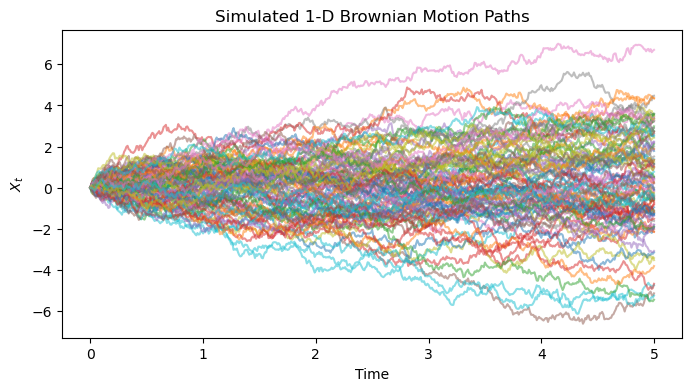

In [8]:
# simulate the 1-D Brownian motion
num_path = 100
num_period = 5
step_size = 500
BM = brownian_motion(num_path, num_period, step_size, random_seed=123)

time_points = np.linspace(0, num_period, step_size + 1)

plt.figure(figsize=(8, 4))
for path in range(BM.shape[0]):
    plt.plot(time_points, BM[path], alpha=0.5)
plt.xlabel("Time")
plt.ylabel("$X_t$")
plt.title("Simulated 1-D Brownian Motion Paths")
plt.show()

In [9]:
# set up an arbitrary neural network for diffusion step
class VF_step_diffusion(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(VF_step_diffusion, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [10]:
def diffusion_model(num_particle: int, step_size: int, sigma: float, random_seed: Optional[int]=None) -> list:

    """
    Simulate the diffusion field of particles using a neural network model.
    Args:
        num_particle (int): Number of particles to simulate.
        step_size (int): Number of steps for the simulation.
        sigma (float): Standard deviation for the diffusion term.
        random_seed (int, optional): Random seed for initial positions. Defaults to None.
    Returns:
        list: A list of numpy arrays representing the history of particle positions.
    """
    
    if random_seed is not None:
        np.random.seed(random_seed)

    # generate initial positions of particles
    X = np.random.normal(0, 1, size=(num_particle, 2))
    X_input = torch.tensor(X, dtype=torch.float32, requires_grad=False).to(device)
    X_history = [X]

    model = VF_step_diffusion(input_size=2, hidden_size=10, output_size=2).to(device)

    t = 0  # time step

    # main
    while t < 1:
        for _ in range(step_size):
            h = 1 / step_size
            with torch.no_grad():
                epsilon = np.random.normal(0, 1, size=(num_particle, 2))
                diffusion_term = torch.tensor(sigma * np.sqrt(h) * epsilon, dtype=torch.float32).to(device)
                X_input = X_input + h * model(X_input) + diffusion_term
            X_history.append(X_input.cpu().detach().numpy())
            t = t + h
    
    return X_history

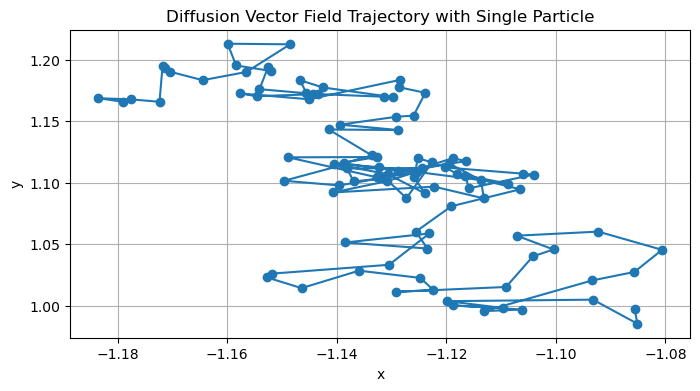

In [11]:
# simulate the trajectory of a single particle in the diffusion model
single_particle_diffusion = diffusion_model(num_particle=1, step_size=100, sigma=0.1, random_seed=123)

x = [single_particle_diffusion[i][0][0] for i in range(len(single_particle_diffusion))]
y = [single_particle_diffusion[i][0][1] for i in range(len(single_particle_diffusion))]

plt.figure(figsize=(8, 4))
plt.plot(x, y, marker="o")
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Diffusion Vector Field Trajectory with Single Particle")
plt.show()

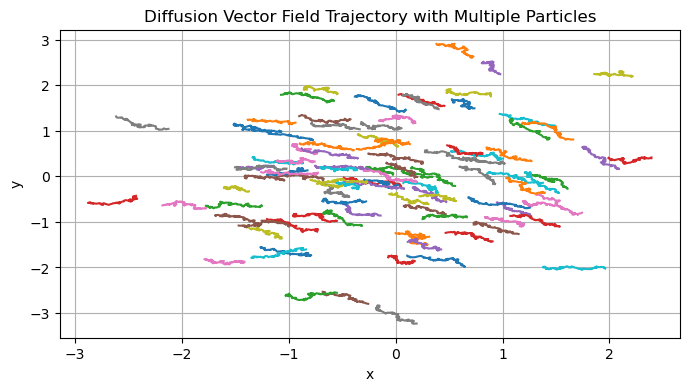

In [12]:
# simulate the trajectory of multiple particles in the diffusion model
multiple_particle_diffusion = diffusion_model(num_particle=100, step_size=100, sigma=0.1, random_seed=123)

particle = {
    f"particle_{j}": [multiple_particle_diffusion[i][j] for i in range(len(multiple_particle_diffusion))]
    for j in range(len(multiple_particle_diffusion[0]))
}

plt.figure(figsize=(8, 4))
for key in particle.keys():
    plt.plot(
        [particle[key][i][0] for i in range(len(particle[key]))], 
        [particle[key][i][1] for i in range(len(particle[key]))]
    )
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Diffusion Vector Field Trajectory with Multiple Particles")
plt.show()

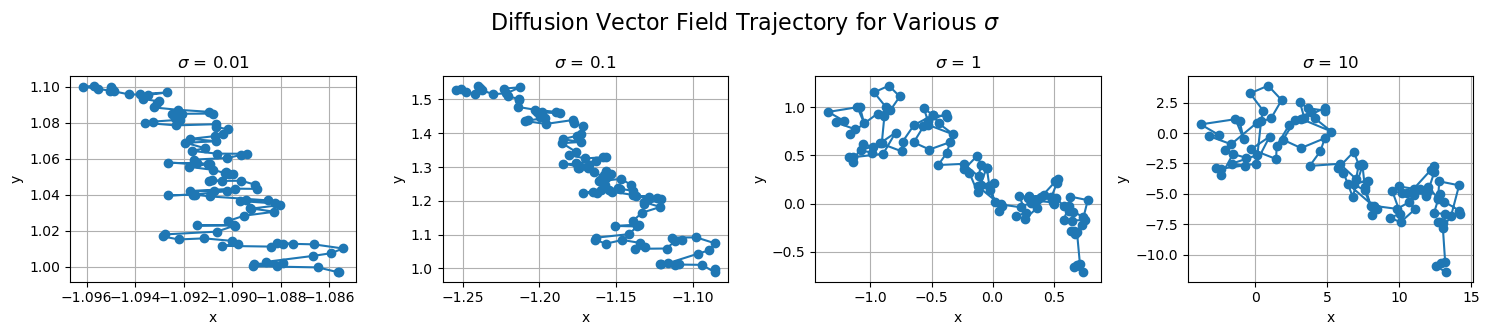

In [13]:
# simulate the trajectory of a single particle in the diffusion model for various sigma values
sigma_list = [0.01, 0.1, 1, 10]
fig, axs = plt.subplots(1, 4, figsize=(15, 3))
axs = axs.flatten()

for idx, sigma in enumerate(sigma_list):
    single_particle_diffusion = diffusion_model(num_particle=1, step_size=100, sigma=sigma, random_seed=123)

    x = [single_particle_diffusion[i][0][0] for i in range(len(single_particle_diffusion))]
    y = [single_particle_diffusion[i][0][1] for i in range(len(single_particle_diffusion))]

    axs[idx].plot(x, y, marker="o")
    axs[idx].grid()
    axs[idx].set_xlabel("x")
    axs[idx].set_ylabel("y")
    axs[idx].set_title(rf"$\sigma$ = {sigma}")

plt.tight_layout()
plt.suptitle(r"Diffusion Vector Field Trajectory for Various $\sigma$", fontsize=16, y=1.1)
plt.show()

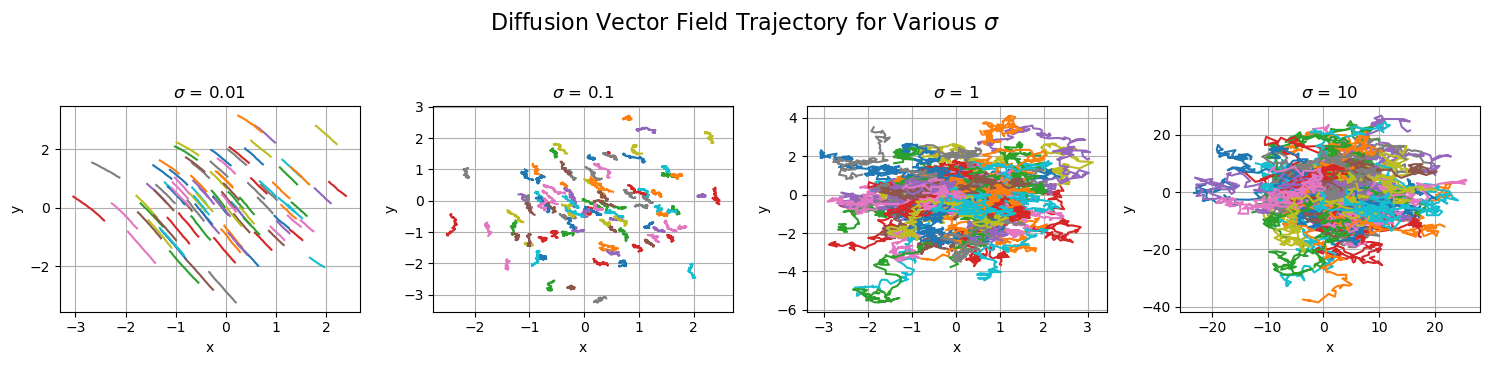

In [14]:
# simulate the trajectory of multiple particles in the diffusion model for various sigma values
sigma_list = [0.01, 0.1, 1, 10]
fig, axs = plt.subplots(1, 4, figsize=(15, 3))
axs = axs.flatten()

for idx, sigma in enumerate(sigma_list):
    multiple_particle_diffusion = diffusion_model(num_particle=100, step_size=100, sigma=sigma, random_seed=123)

    particle = {
        f"particle_{j}": [multiple_particle_diffusion[i][j] for i in range(len(multiple_particle_diffusion))]
        for j in range(len(multiple_particle_diffusion[0]))
    }
    for key in particle.keys():
        axs[idx].plot(
            [particle[key][i][0] for i in range(len(particle[key]))], 
            [particle[key][i][1] for i in range(len(particle[key]))]
        )
    axs[idx].grid()
    axs[idx].set_xlabel("x")
    axs[idx].set_ylabel("y")
    axs[idx].set_title(rf"$\sigma$ = {sigma}")

plt.tight_layout()
plt.suptitle(r"Diffusion Vector Field Trajectory for Various $\sigma$", fontsize=16, y=1.2)
plt.show()

# 2.3 More Example, Simulation, and Discussion
---

In [15]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Implementing Brownian Motion with various sigma
給定初始條件 $X_0 = 0$，
$$
dX_t = \sigma dW_t
$$

In [16]:
def brownian_motion_2(num_path: int, num_period: float, step_size: int, sigma: float, random_seed: Optional[int]=None) -> np.ndarray:

    """
    Simulate the 1-D Brownian motion.
    Args:
        num_path (int): Number of paths to simulate.
        num_period (float): Total time duration.
        step_size (int): Number of discrete time steps.
        sigma (float): Diffusion term for the Brownian motion.
        random_seed (int, optional): Random seed for reproducibility. Defaults to None.
    Returns:
        np.ndarray: A 1D array of shape (num_path, step_size) representing the Brownian motion paths.
    """
    
    if random_seed is not None:
        np.random.seed(random_seed)
    
    dt = num_period / step_size
    dW = sigma * np.sqrt(dt) * np.random.randn(num_path, step_size)
    X = np.cumsum(dW, axis=1)
    X = np.hstack((np.zeros((num_path, 1)), X)) # add initial position at t=0
    
    return X

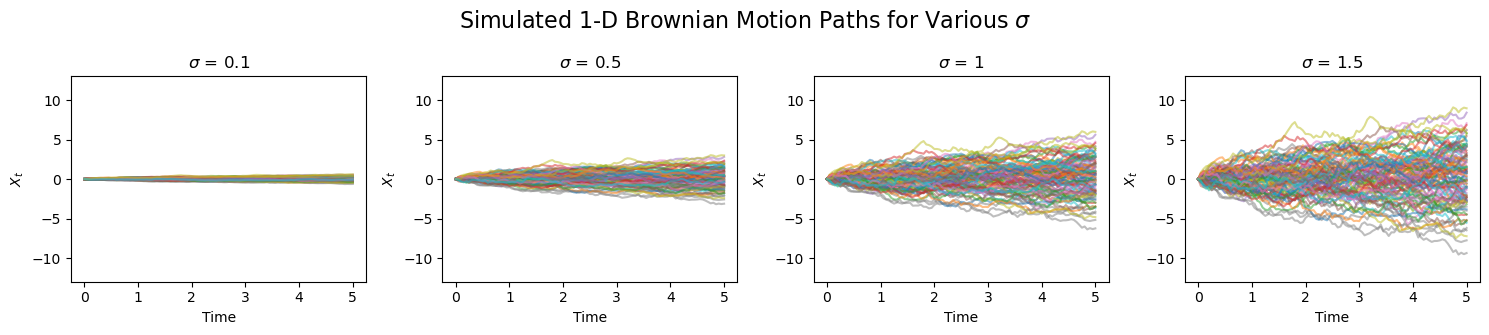

In [17]:
# simulate the 1-D Brownian motion with various sigma values
sigma_list = [0.1, 0.5, 1, 1.5]
num_path = 100
num_period = 5
step_size = 100
time_points = np.linspace(0, num_period, step_size + 1)

fig, axs = plt.subplots(1, 4, figsize=(15, 3))
axs = axs.flatten()

for idx, sigma in enumerate(sigma_list):
    BM_2 = brownian_motion_2(num_path, num_period, step_size, sigma, random_seed=123)
    for path in range(BM_2.shape[0]):
        axs[idx].plot(time_points, BM_2[path], alpha=0.5)
    axs[idx].set_ylim([-13, 13])
    axs[idx].set_xlabel("Time")
    axs[idx].set_ylabel("$X_t$")
    axs[idx].set_title(rf"$\sigma$ = {sigma}")

plt.tight_layout()
plt.suptitle(r"Simulated 1-D Brownian Motion Paths for Various $\sigma$", fontsize=16, y=1.1)
plt.show()

---
## 2. Implementing an Ornstein-Uhlenbeck Process
對於一個 Ornstein-Uhlenbeck 過程 (OU process)，其趨勢項 $u_t(X_t) = -\theta X_t$ 以及隨機項 $\sigma_t = \sigma$，即給定初始條件 $X_0 = x_0$，
$$
dX_t = -\theta X_t dt + \sigma dW_t
$$

<span style="color: grey">**Note**: OU 過程為一種具有均數回歸性質的隨機過程，其回復速度為 $\theta$。</span>

In [18]:
def OU_process(num_path: int, num_period: float, step_size: int, 
               theta: float, sigma: float, random_seed: Optional[int]=None) -> np.ndarray:

    """
    Simulate the 1-D Ornstein–Uhlenbeck (OU) process using Euler–Maruyama method.
    
    Args:
        num_path (int): Number of paths to simulate.
        num_period (float): Total time duration.
        step_size (int): Number of discrete time steps.
        theta (float): Mean-reversion rate.
        sigma (float): Volatility parameter.
        random_seed (int, optional): Random seed for reproducibility.
        
    Returns:
        np.ndarray: Array of shape (num_path, step_size + 1) with OU process paths.
    """
    
    if random_seed is not None:
        np.random.seed(random_seed)
    
    dt = num_period / step_size

    X = np.zeros((num_path, step_size + 1))
    X[:, 0] = np.linspace(-10, 10, num_path)

    for i in range(1, step_size + 1):
        dW = np.sqrt(dt) * np.random.randn(num_path)
        X[:, i] = X[:, i - 1] - theta * X[:, i - 1] * dt + sigma * dW
    
    return X

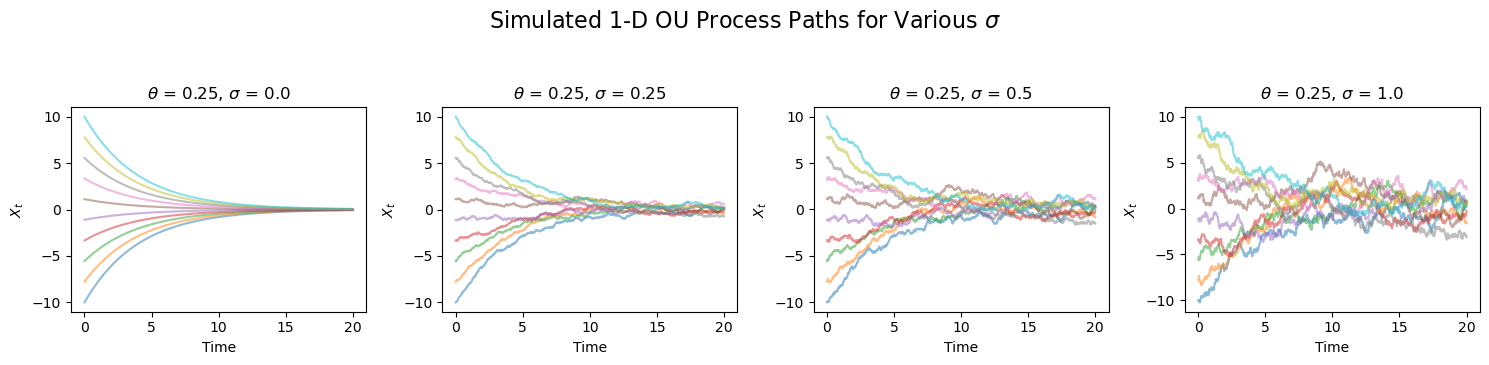

In [19]:
# simulate the 1-D OU process with various sigma values
parameters = [
    (0.25, 0.0), 
    (0.25, 0.25), 
    (0.25, 0.5), 
    (0.25, 1.0)
]
num_path = 10
num_period = 20
step_size = 1000
time_points = np.linspace(0, num_period, step_size + 1)

fig, axs = plt.subplots(1, 4, figsize=(15, 3))
axs = axs.flatten()

for idx, (theta, sigma) in enumerate(parameters):
    OU = OU_process(num_path, num_period, step_size, theta, sigma, random_seed=123)
    for path in range(OU.shape[0]):
        axs[idx].plot(time_points, OU[path], alpha=0.5)
    axs[idx].set_xlabel("Time")
    axs[idx].set_ylabel("$X_t$")
    axs[idx].set_title(rf"$\theta$ = {theta}, $\sigma$ = {sigma}")

plt.tight_layout()
plt.suptitle(r"Simulated 1-D OU Process Paths for Various $\sigma$", fontsize=16, y=1.2)
plt.show()

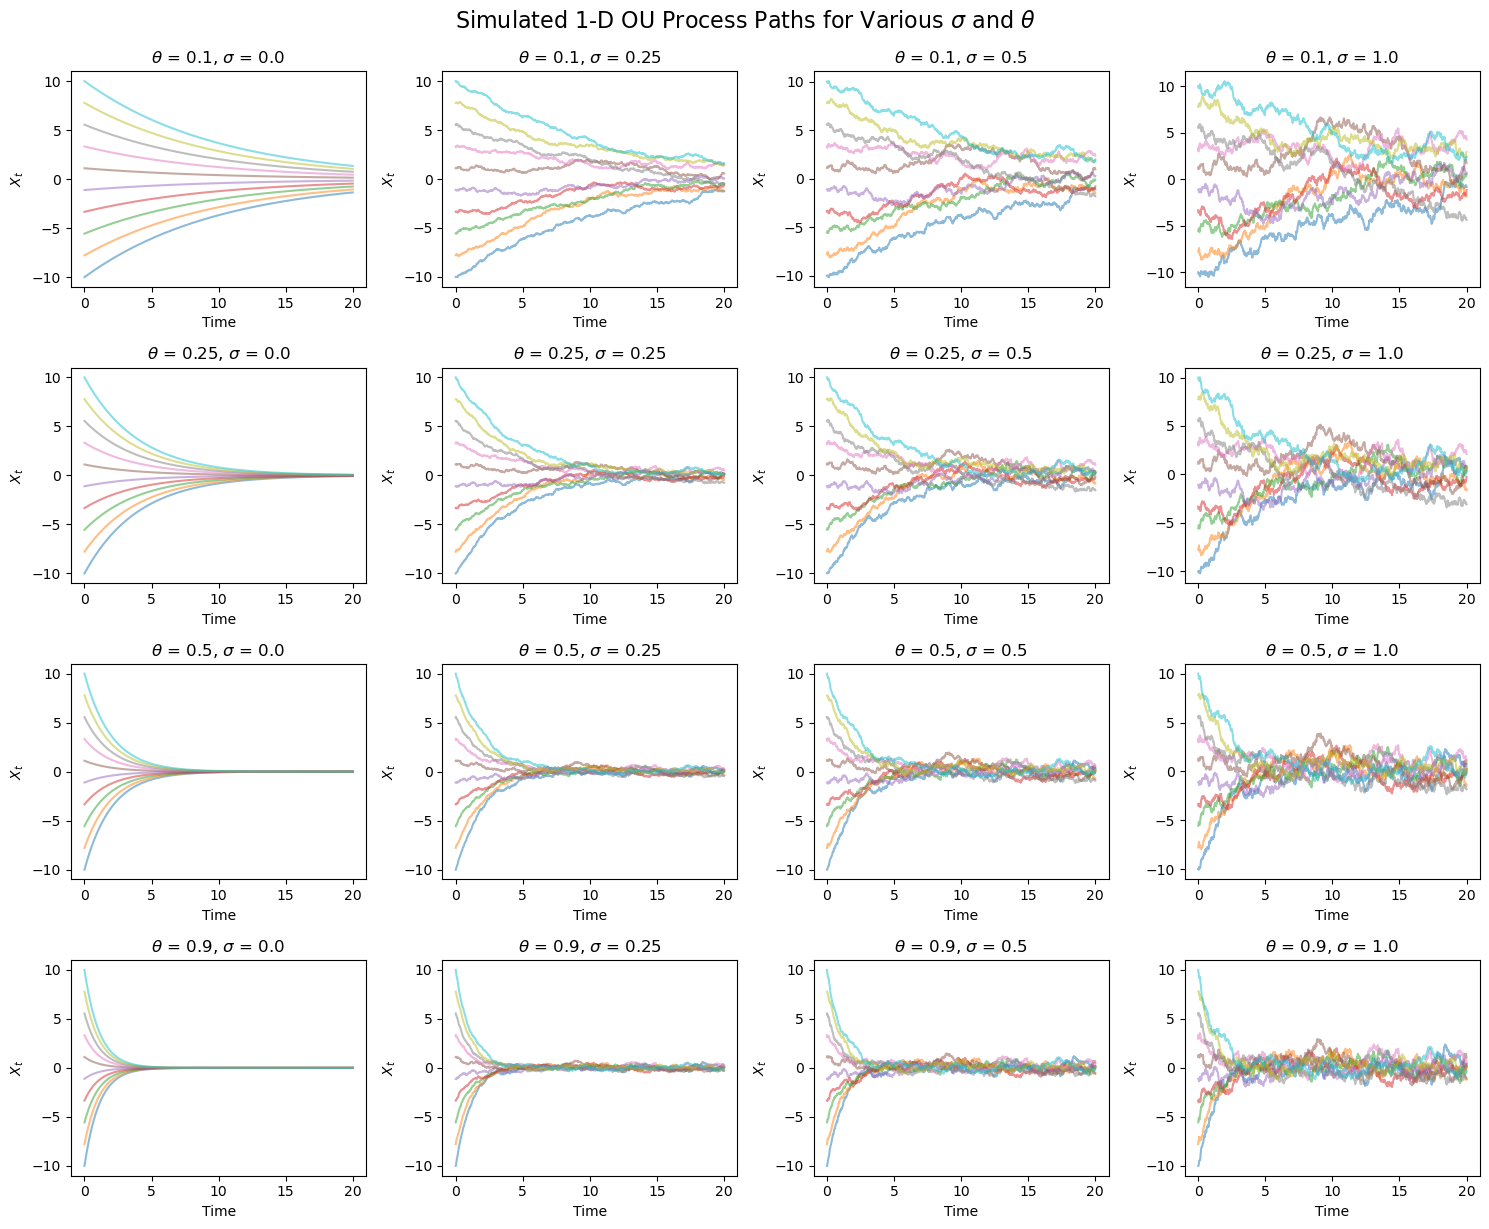

In [20]:
# simulate the 1-D OU process with various sigma values and theta values
parameters = [(theta, sigma) for theta in [0.1, 0.25, 0.5, 0.9] for sigma in [0.0, 0.25, 0.5, 1.0]]
num_path = 10
num_period = 20
step_size = 1000
time_points = np.linspace(0, num_period, step_size + 1)

fig, axs = plt.subplots(4, 4, figsize=(15, 12))
axs = axs.flatten()

for idx, (theta, sigma) in enumerate(parameters):
    OU = OU_process(num_path, num_period, step_size, theta, sigma, random_seed=123)
    for path in range(OU.shape[0]):
        axs[idx].plot(time_points, OU[path], alpha=0.5)
    axs[idx].set_xlabel("Time")
    axs[idx].set_ylabel("$X_t$")
    axs[idx].set_title(rf"$\theta$ = {theta}, $\sigma$ = {sigma}")

plt.tight_layout()
plt.suptitle(r"Simulated 1-D OU Process Paths for Various $\sigma$ and $\theta$", fontsize=16, y=1.02)
plt.show()

---
## 3. Simulating Diffusion Models with OU Process

以下模擬為嘗試在 Diffusion models 中結合 OU 過程，來展示對粒子的影響。

In [21]:
def diffusion_model_OU(num_particle: int, step_size: int, theta: float, sigma: float, random_seed: Optional[int]=None) -> list:

    """
    Simulate the diffusion field of particles based on OU process.
    Args:
        num_particle (int): Number of particles to simulate.
        step_size (int): Number of steps for the simulation.
        theta (float): Mean-reversion rate for the OU process.
        sigma (float): Standard deviation for the diffusion term.
        random_seed (int, optional): Random seed for initial positions. Defaults to None.
    Returns:
        list: A list of numpy arrays representing the history of particle positions.
    """
    
    if random_seed is not None:
        np.random.seed(random_seed)

    # generate initial positions of particles
    X = np.random.normal(0, 1, size=(num_particle, 2))
    X_input = torch.tensor(X, dtype=torch.float32, requires_grad=False).to(device)
    X_history = [X]

    model = VF_step_diffusion(input_size=2, hidden_size=10, output_size=2).to(device)

    t = 0  # time step

    # main
    while t < 1:
        for _ in range(step_size):
            h = 1 / step_size
            with torch.no_grad():
                epsilon = np.random.normal(0, 1, size=(num_particle, 2))
                diffusion_term = torch.tensor(sigma * np.sqrt(h) * epsilon, dtype=torch.float32).to(device)
                X_input = X_input - theta * h * model(X_input) + diffusion_term
            X_history.append(X_input.cpu().detach().numpy())
            t = t + h
    
    return X_history

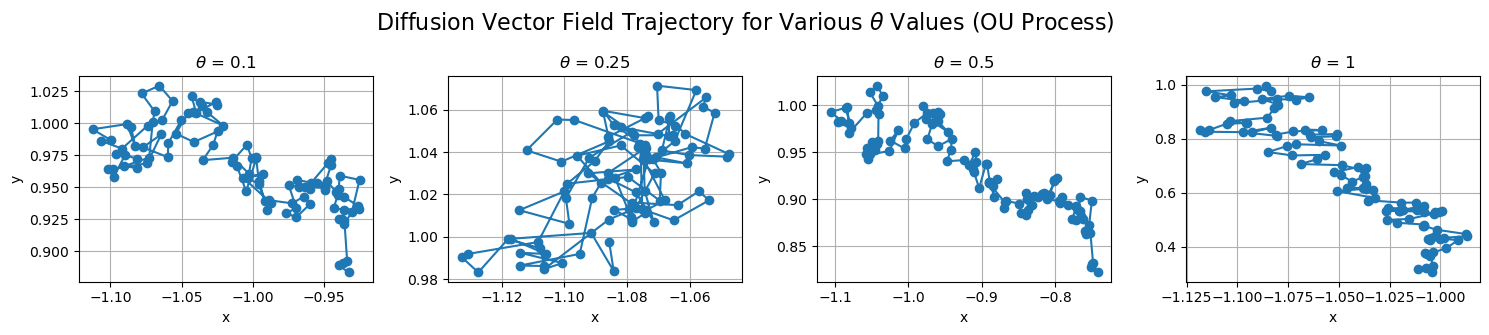

In [22]:
# simulate the trajectory of a single particle in the diffusion model based on the OU process with various theta values
theta_list = [0.1, 0.25, 0.5, 1]
fig, axs = plt.subplots(1, 4, figsize=(15, 3))
axs = axs.flatten()

for idx, theta in enumerate(theta_list):
    single_particle_OU = diffusion_model_OU(num_particle=1, step_size=100, theta=theta, sigma=0.1, random_seed=123)

    x = [single_particle_OU[i][0][0] for i in range(len(single_particle_OU))]
    y = [single_particle_OU[i][0][1] for i in range(len(single_particle_OU))]

    axs[idx].plot(x, y, marker="o")
    axs[idx].grid()
    axs[idx].set_xlabel("x")
    axs[idx].set_ylabel("y")
    axs[idx].set_title(rf"$\theta$ = {theta}")

plt.tight_layout()
plt.suptitle(r"Diffusion Vector Field Trajectory for Various $\theta$ Values (OU Process)", fontsize=16, y=1.1)
plt.show()

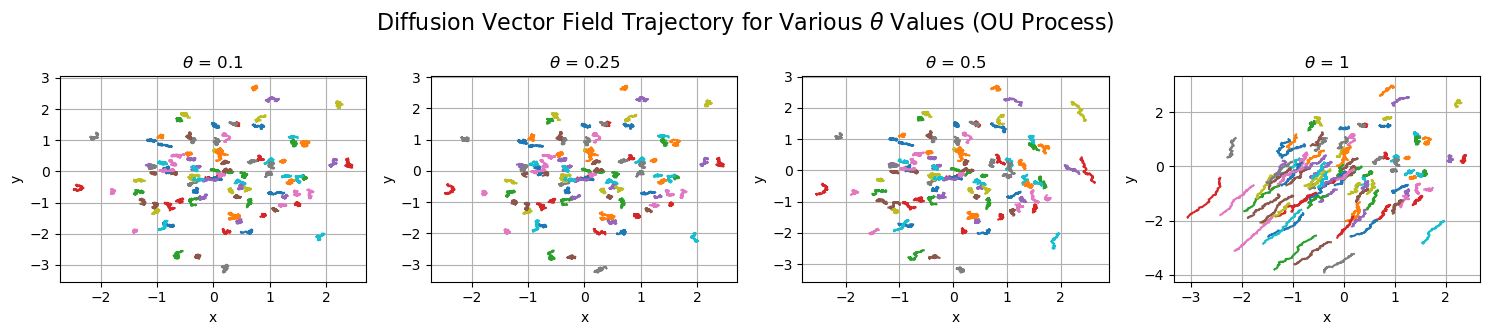

In [23]:
# simulate the trajectory of multiple particles in the diffusion model based on the OU process with various theta values
theta_list = [0.1, 0.25, 0.5, 1]
fig, axs = plt.subplots(1, 4, figsize=(15, 3))
axs = axs.flatten()

for idx, theta in enumerate(theta_list):
    multiple_particle_OU = diffusion_model_OU(num_particle=100, step_size=100, theta=theta, sigma=0.1, random_seed=123)

    particle = {
        f"particle_{j}": [multiple_particle_OU[i][j] for i in range(len(multiple_particle_OU))]
        for j in range(len(multiple_particle_OU[0]))
    }
    for key in particle.keys():
        axs[idx].plot(
            [particle[key][i][0] for i in range(len(particle[key]))], 
            [particle[key][i][1] for i in range(len(particle[key]))]
        )
    axs[idx].grid()
    axs[idx].set_xlabel("x")
    axs[idx].set_ylabel("y")
    axs[idx].set_title(rf"$\theta$ = {theta}")

plt.tight_layout()
plt.suptitle(r"Diffusion Vector Field Trajectory for Various $\theta$ Values (OU Process)", fontsize=16, y=1.1)
plt.show()

---
## 4. Transforming Distribution with SDEs
上述的隨機過程都是觀察粒子如何被 SDEs 所轉換；然而，我們真正的目標是想要轉換一個分佈，也就是如何從 $p_{\text{init}}$ 變成 $p_{\text{data}}$。

在文獻上有一種 SDEs 可以完成這件事，也就是 **Langvein dynamic**，其表達式如下：
$$
dX_t = \frac{1}{2} \sigma^2 \nabla \log p(X_t) dt + \sigma dWt
$$

對於這個分佈我們有一些限制：
1. 該分佈可以進行微分或者是說計算梯度
2. 我們可以從這個分佈進行抽樣

這裡我們同樣對 Langvein dynamic 進行一些簡單的模擬。

*Case 1.* 假設 $X \sim N(0, 1)$，則 $p(x) \propto e^{-x^2/x}$ 且
$$
\nabla \log p(x) = -x
$$

In [24]:
def Langvein_dynamic(num_path: int, num_period: float, step_size: int, sigma: float, 
                     random_seed: Optional[int]=None) -> np.ndarray:
    
    """
    Simulate the Langvein dynamic process.
    Args:
        num_path (int): Number of paths to simulate.
        num_period (float): Total time duration.
        step_size (int): Number of discrete time steps.
        sigma (float): Standard deviation for the diffusion term.
        random_seed (int, optional): Random seed for reproducibility. Defaults to None.
    Returns:
        np.ndarray: A 1D array of shape (num_path, step_size + 1) representing the Langvein dynamic paths.
    """
    
    if random_seed is not None:
        np.random.seed(random_seed)
    
    dt = num_period / step_size

    X = np.zeros((num_path, step_size + 1))
    X[:, 0] = np.random.randn(num_path) # initial positions

    for i in range(1, step_size + 1):
        score = -X[:, i - 1]
        dW = np.sqrt(dt) * np.random.randn(num_path)
        X[:, i] = X[:, i - 1] + 0.5 * sigma ** 2 * score * dt + sigma * dW
    
    return X

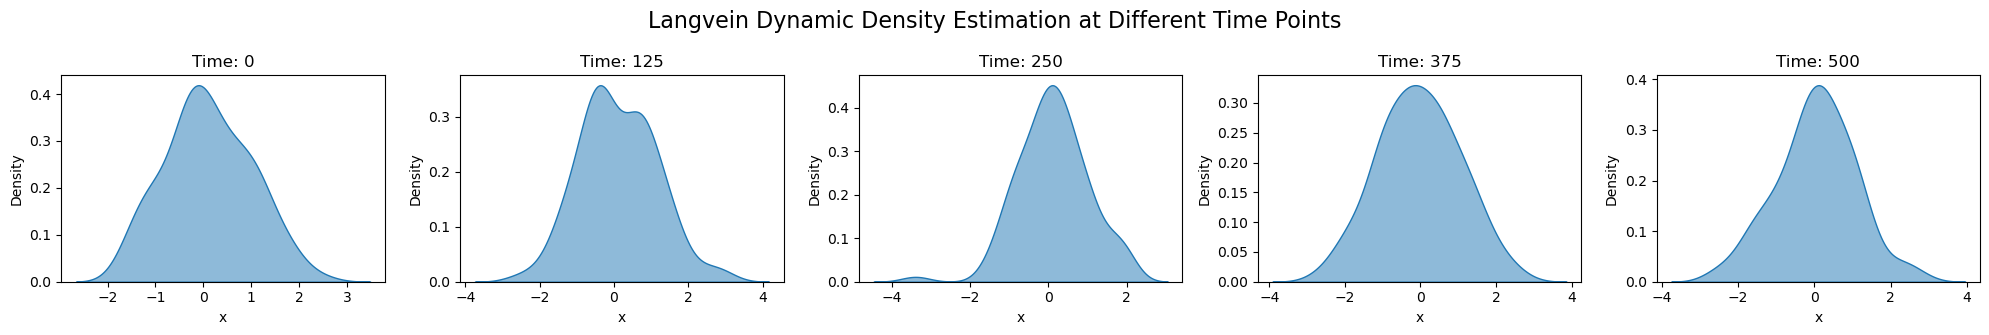

In [25]:
# simulate the Langvein dynamic density estimation at different time points
num_path = 100
num_period = 20
step_size = 500
time_points = np.linspace(0, 500, 5)

Langvein = Langvein_dynamic(num_path, num_period, step_size, sigma=1)

particle = {f"particle_{j}": [Langvein[i][j] for i in range(len(Langvein))]
            for j in range(len(Langvein[0]))}

fig, axs = plt.subplots(1, 5, figsize=(20, 3))
axs = axs.flatten()

for idx, key in enumerate(time_points):
    key = int(key)
    sns.kdeplot(particle[f"particle_{key}"], ax=axs[idx], fill=True, alpha=0.5)
    axs[idx].set_title(f"Time: {key}")
    axs[idx].set_xlabel("x")
    axs[idx].set_ylabel("Density")
plt.tight_layout()
plt.suptitle("Langvein Dynamic Density Estimation at Different Time Points", fontsize=16, y=1.1)
plt.show()

*Case 2.* 假設 $\mathbf{X} \sim \mathcal{N}_2(\mu, \Sigma)$，則
$$
\nabla \log p(x) \propto - \Sigma^{-1} (\mathbf{x} - \mu)
$$

In [26]:
def Langvein_dynamic_2D(num_path: int, num_period: float, step_size: int, sigma: float, 
                        mu: np.ndarray, cov: np.ndarray, random_seed: Optional[int]=None) -> np.ndarray:
    
    """
    Simulate the 2-D Langvein dynamic process.
    Args:
        num_path (int): Number of paths to simulate.
        num_period (float): Total time duration.
        step_size (int): Number of discrete time steps.
        sigma (float): Standard deviation for the diffusion term.
        mu (np.ndarray): Mean vector for the multivariate normal distribution.
        cov (np.ndarray): Covariance matrix for the multivariate normal distribution.
        random_seed (int, optional): Random seed for reproducibility. Defaults to None.
    Returns:
        np.ndarray: A 2D array of shape (num_path, step_size + 1, 2) representing the Langvein dynamic paths.
    """
    
    if random_seed is not None:
        np.random.seed(random_seed)
    
    dt = num_period / step_size
    dim = 2
    inv_cov = np.linalg.inv(cov)

    X = np.zeros((num_path, step_size + 1, dim))
    X[:, 0, :] = np.random.multivariate_normal(mean=mu, cov=cov, size=num_path) # initial positions

    for i in range(1, step_size + 1):
        score = -((X[:, i - 1, :] - mu) @ inv_cov.T)  # score function
        dW = np.sqrt(dt) * np.random.randn(num_path, dim)
        X[:, i, :] = X[:, i - 1, :] + 0.5 * sigma ** 2 * score * dt + sigma * dW
    
    return X

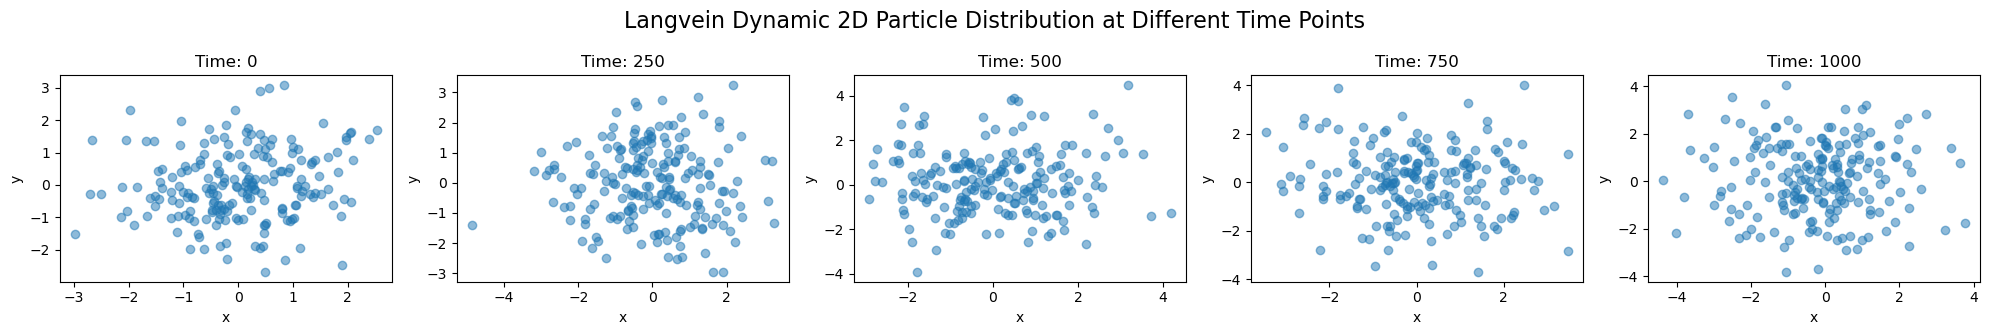

In [27]:
# simulate the Langvein dynamic distribution estimation at different time points
num_path = 200
num_period = 20
step_size = 1000
time_points = np.linspace(0, step_size, 5)

Langvein_2D = Langvein_dynamic_2D(num_path, num_period, step_size, sigma=10, mu=np.zeros(2), cov=np.eye(2))

particle_2D = {f"particle_{j}": [Langvein_2D[i][j] for i in range(len(Langvein_2D))] for j in range(len(Langvein_2D[0]))}

fig, axs = plt.subplots(1, 5, figsize=(20, 3))
axs = axs.flatten()

for idx, key in enumerate(time_points):
    key = int(key)
    x = [particle_2D[f"particle_{key}"][i][0] for i in range(len(particle_2D[f"particle_{key}"]))]
    y = [particle_2D[f"particle_{key}"][i][1] for i in range(len(particle_2D[f"particle_{key}"]))]
    axs[idx].scatter(x, y, alpha=0.5)
    axs[idx].set_title(f"Time: {key}")
    axs[idx].set_xlabel("x")
    axs[idx].set_ylabel("y")
plt.tight_layout()
plt.suptitle("Langvein Dynamic 2D Particle Distribution at Different Time Points", fontsize=16, y=1.1)
plt.show()

In [28]:
def diffusion_model_Langvein(num_particle: int, step_size: int, sigma: float, random_seed: Optional[int]=None) -> list:

    """
    Simulate the diffusion field of particles based on Langvein dynamic and case 1.
    Args:
        num_particle (int): Number of particles to simulate.
        step_size (int): Number of steps for the simulation.
        sigma (float): Standard deviation for the diffusion term.
        random_seed (int, optional): Random seed for initial positions. Defaults to None.
    Returns:
        list: A list of numpy arrays representing the history of particle positions.
    """
    
    if random_seed is not None:
        np.random.seed(random_seed)

    # generate initial positions of particles
    X = np.random.normal(0, 1, size=(num_particle, 2))
    X_input = torch.tensor(X, dtype=torch.float32, requires_grad=False).to(device)
    X_history = [X]

    model = VF_step_diffusion(input_size=2, hidden_size=10, output_size=2).to(device)

    t = 0  # time step

    # main
    while t < 1:
        for _ in range(step_size):
            h = 1 / step_size
            with torch.no_grad():
                score = -X_input
                epsilon = np.random.normal(0, 1, size=(num_particle, 2))
                diffusion_term = torch.tensor(sigma * np.sqrt(h) * epsilon, dtype=torch.float32).to(device)
                X_input = X_input + 0.5 * sigma ** 2 * score * h * model(X_input) + diffusion_term
            X_history.append(X_input.cpu().detach().numpy())
            t = t + h
    
    return X_history

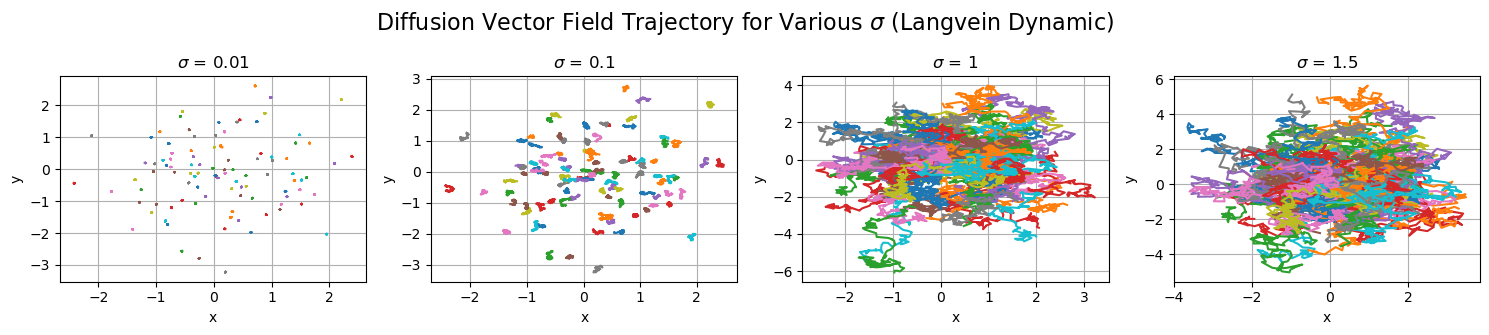

In [29]:
# simulate the trajectory of multiple particles in the diffusion model for various sigma values
sigma_list = [0.01, 0.1, 1, 1.5]
fig, axs = plt.subplots(1, 4, figsize=(15, 3))
axs = axs.flatten()

for idx, sigma in enumerate(sigma_list):
    multiple_particle_diffusion = diffusion_model_Langvein(num_particle=100, step_size=100, sigma=sigma, random_seed=123)

    particle = {
        f"particle_{j}": [multiple_particle_diffusion[i][j] for i in range(len(multiple_particle_diffusion))]
        for j in range(len(multiple_particle_diffusion[0]))
    }
    for key in particle.keys():
        axs[idx].plot(
            [particle[key][i][0] for i in range(len(particle[key]))], 
            [particle[key][i][1] for i in range(len(particle[key]))]
        )
    axs[idx].grid()
    axs[idx].set_xlabel("x")
    axs[idx].set_ylabel("y")
    axs[idx].set_title(rf"$\sigma$ = {sigma}")

plt.tight_layout()
plt.suptitle(r"Diffusion Vector Field Trajectory for Various $\sigma$ (Langvein Dynamic)", fontsize=16, y=1.1)
plt.show()